<a href="https://colab.research.google.com/github/Cheesykung/Sugar-cane-leaves-Recognition/blob/master/real_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **โปรเจค 3 การทำ Image Recognition แบบ Learning-Based Approach**

### **`กลุ่ม หม่าล่าอ่ะเผ็ดแต่ไม่เด็ดเท่าเรา`**

>  # ***การรู้จำภาพใบอ้อย***

เพื่อจำแนกโรคใบอ้อย ได้แก่
*   ใบอ้อยที่ไม่เป็นโรค (green)
*   ใบอ้อยที่เป็นโรคใบขีดแดง (red)
*   ใบอ้อยที่เป็นโรคใบจุดวงแหวน (ring)
*   ใบอ้อยที่เป็นโรคใบจุดตาล (spot)
*   ใบอ้อยที่เป็นโรคใบด่าง (white)
*   ใบอ้อยที่เป็นโรคใบเหลือง (yellow)







In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Mount Drive เพื่อเชื่อมต่อกับข้อมูลใน Google Drive
import pathlib
data_dir = '/content/drive/MyDrive/Project-sugarcane'
data_dir = pathlib.Path(data_dir) # รับ path มาแปลงเป็น path class

In [ ]:
#a = (list(data_dir.glob('*/*.JPG')))
#print(a[0])
#print(new_filename)

In [ ]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

60


# **SETTING DATASET**

In [ ]:
# fixed size training resources and label
# กำหนดขนาดภาพที่จะเข้ามา train
batch_size = 4 # จำนวนภาพที่นำมาเข้าชุดในการ train และ test model
img_height = 256 # ความสูงภาพ
img_width = 256 # ความกว้างภาพ
img_size = (img_height,img_width)

In [ ]:
# training data selection
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, # กำหนด path ที่อยู่ของข้อมูล โดยพารามิเตอร์นี้จะกำหนด Sub-directory เป็น Label และมองไฟล์ภาพ เป็นภาพของ Class นั้น ๆ 
  validation_split= 0.3, # กำหนด % ของจำนวนภาพที่จะเอาไป Test
  subset = "training", #กำหนดว่าเป็นชุด Train 
  seed = 123, # Optional random seed for shuffling and transformations. กำหนดให้มีการสุ่มลำดับในการสลับหรือการแปลงภาพ
  image_size = (img_height, img_width), #กำหนดขนาด 256*256
  batch_size = batch_size) # จากภาพทั้งหมด จะนำเข้าชุดข้อมูลเพื่อไปทำการ Train และ Test model ทั้งหมด 60 ภาพ

Found 60 files belonging to 6 classes.
Using 42 files for training.


In [ ]:
# testing data selection
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset = "validation", #กำหนดว่าเป็นชุด Test
  seed= 123, 
  image_size=(img_height, img_width),
  batch_size = batch_size)
class_names = train_dataset.class_names

Found 60 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
class_names = train_dataset.class_names
print(class_names)
num_classes = len(train_dataset.class_names)
print(num_classes)

['green', 'red', 'ring', 'spot', 'white', 'yellow']
6


In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 256, 256, 3)
(4,)


# **Preprocessing data**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

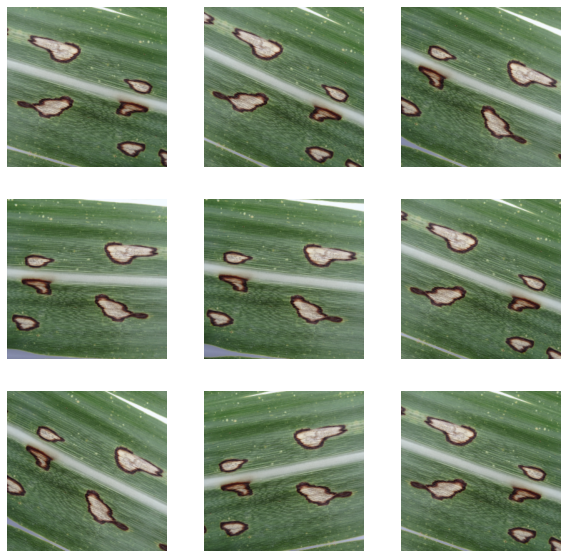

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.experimental.preprocessing.Rescaling(1./255)(x)

NameError: ignored

(256, 256)

# **เดี๋ยวมาเรียนรู้**

มันเหมือนเอาไว้หา one hot ได้ ซึ่ง one hot คืออะไร๊

In [ ]:
# Normalize pixel value to between 0 and 1
#normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))



In [ ]:
#print(image_batch[0]) 

In [ ]:
print(labels_batch)

tf.Tensor([4 5 0 1], shape=(4,), dtype=int32)


In [ ]:
#print(normalized_ds)

In [ ]:
#print("train_dataset : " ,train_dataset)
#print("test_dataset : " , test_dataset)

# **CREATE Model CONSTRUCTER**

---



In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=img_size + (3,), num_classes=6)


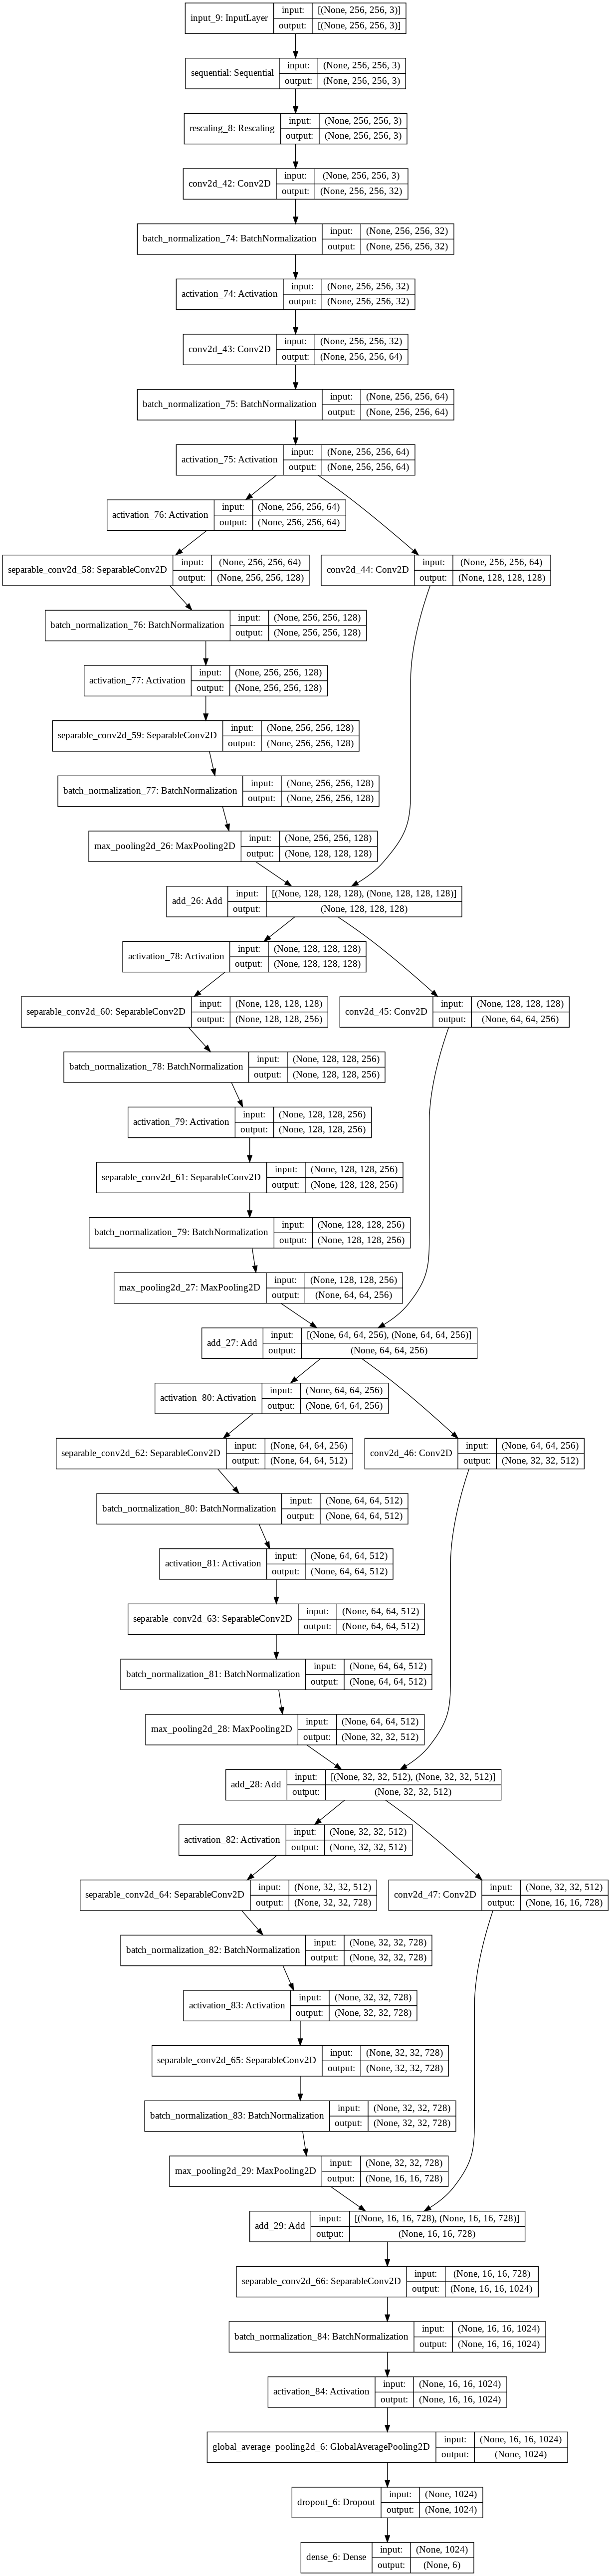

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# **TEST**

In [ ]:
# create Model
num_classes = 
model = Sequential([

  # กำหนดส่วนที่ทำให้ model Robustness
  # เพิ่ม Layer สุ่ม flip ภาพแนวนอนแนวตั้ง
  #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  # เพิ่ม Layer ในการปรับขนาดภาพที่ input จาก [0,255] เป็น [0,1]
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # เพิ่ม Layer สุ่มหมุนภาพ
  # layers.experimental.preprocessing.RandomRotation(0.0),
  # เพิ่ม Layer สุ่ม Zoom in 20%
  # layers.experimental.preprocessing.RandomZoom(-0.2),
  
  # กำหนดส่วน Feature Extraction สกัด Feature
  # สร้าง 1st convolution layer ที่มี output layer = 6 ; kernel ขนาด 6*6 และมีการทำ activation แบบ relu ไม่มีการทำ padding
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  # สร้าง MaxPooling layer ขนาด 2*2
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  
  layers.Conv2D(64, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),

  layers.Conv2D(128, 3, activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),

  #  เพิ่ม Dropout layer ที่มี Rate การ Drop ที่ 50% 
  layers.Dropout(0.5),
  
  # กำหนดการทำการ Classify - Fully connected
  # รวม feature extraction แต่ละ pixel ให้เป็น Vector
  layers.Flatten(),
  # Dense
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  #  เพิ่ม Dropout layer ที่มี Rate การ Drop ที่ 50% 
  layers.Dropout(0.5),
  # เพิ่ม perceptron
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  #  เพิ่ม Dropout layer ที่มี Rate การ Drop ที่ 50% 
  layers.Dropout(0.5),
  # สร้าง layer สุดท้าย หรือ layer output ที่มีขนาดเท่ากับจำนวน Class Label = 6
  layers.Dense(num_classes, activation='softmax'),
])



In [ ]:
# Print network layer of Model
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 256, 256, 3)  0           sequential[8][0]                 
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 32) 896         rescaling_8[0][0]                
____________________________________________________________________________________________

# **Training dataset**

In [ ]:
#กำหนดครั้ง ที่นำทุกภาพใน batch_size เข้าไป Train 
epochs = 5 

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
# สอน Model ปรับปรุงแบบจำลอง --> Backward
# ทำการ optimizer ด้วย Adam Algorithms
# ทำการ Crossentropy loss function เพราะมีมากกว่า 2 class label มาช่วยปรับค่า 
# > classes floating point values per feature for y_pred and a single floating point value per feature for y_true
# > The shape of y_true is [batch_size] and the shape of y_pred is [batch_size, num_classes]
# เก็บค่า Metrics เพื่อคำนวณหาความถี่ที่ค่า predict = labels
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


# fit model สั่งให้โยนภาพ ไปให้โมเดลเรียนรู้

history = model.fit(
  train_dataset,
  validation_data = test_dataset,
  epochs = epochs
)

Epoch 1/5
11/11 [==============================] - 65s 6s/step - loss: 2.0665 - accuracy: 0.1666 - val_loss: 1.7907 - val_accuracy: 0.1111
Epoch 2/5
11/11 [==============================] - 62s 6s/step - loss: 1.5180 - accuracy: 0.4573 - val_loss: 1.7790 - val_accuracy: 0.1111
Epoch 3/5
11/11 [==============================] - 62s 6s/step - loss: 1.3562 - accuracy: 0.5840 - val_loss: 1.7867 - val_accuracy: 0.1111
Epoch 4/5
11/11 [==============================] - 62s 6s/step - loss: 1.0501 - accuracy: 0.4766 - val_loss: 1.8324 - val_accuracy: 0.1111
Epoch 5/5
11/11 [==============================] - 62s 6s/step - loss: 0.9700 - accuracy: 0.6846 - val_loss: 1.8814 - val_accuracy: 0.1111


# **Visualize training results**

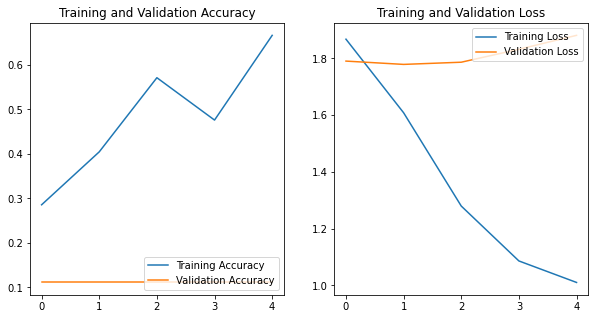

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) # plot กราฟ 1 แถว 2 หลัก index ที่ 1
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # plot กราฟ 1 แถว 2 หลัก index ที่ 2
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Average Accuracy train ", sum(acc)/len(acc))
print("Average Accuracy test ", sum(val_acc)/len(val_acc))
print("Average Loss train ", sum(loss)/len(loss))
print("Average Loss test ", sum(val_loss)/len(val_loss))

Average Accuracy train  0.5809523910284042
Average Accuracy test  0.1444444477558136
Average Loss train  1.0897660613059998
Average Loss test  2.1621503233909607


# **Evaluate Model**

In [ ]:
# Evaluate model by using test_dataset
model.evaluate(test_dataset)
# --->> Returns the loss value & metrics values for the model in test mode. Computation is done in batches

5/5 [==============================] - 2s 311ms/step - loss: 2.9100 - accuracy: 0.1111


[2.909992218017578, 0.1111111119389534]

# **PREDICT CLASS OF IMAGE** 

  - `Import file จาก local storage`
  - `Input path from google drive`

---




# `> แบบ Import file จาก local storage`

  

> *หมายเหตุ : การอัปโหลดช้ากว่าการใส่ directory path *italicized text*



  



In [ ]:
# input ภาพที่ต้องการ predict class
from google.colab import files
predict_files = files.upload()

TypeError: ignored

In [ ]:
print(type(predict_files))
key = predict_files.keys()
key_list = list(predict_files.keys())
print(key_list)

In [ ]:
from skimage.transform import resize
predict_file = plt.imread(key_list[0])
show_predict_file = plt.imshow(predict_file)

In [ ]:
predict_file = resize(predict_file, (img_height,img_width))
show_predict_file_resize = plt.imshow(predict_file)

In [ ]:
file_predictions = model.predict(np.array([predict_file]))
print(file_predictions)
file_score = tf.nn.softmax(file_predictions[0])
print(file_score)

print(
    "This image most likely belongs to {} class with a {:.2f} percent confidence.".format(class_names[np.argmax(file_score)], 100 * np.max(file_score))
)



# `> แบบ input path from google drive`



> *หมายเหตุ : ต้อง Mount Drive กับ Google colab ก่อน หรือ ใส่ path ของภาพจาก local storage







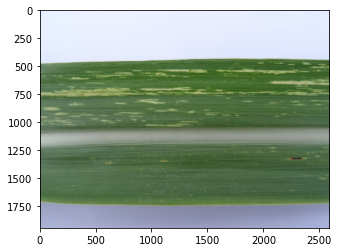

In [ ]:

sunflower_path = '/content/drive/MyDrive/Project-sugarcane/white/DSC00143.JPG'

# นำเข้าภาพ และปรับขนาดให้เท่ากับขนาดภาพ test ให้เท่ากับ ภาพที่ train ใน model
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
predict_file = plt.imread(sunflower_path)
show_predict_file = plt.imshow(predict_file)
# แปลง ภาพ เป็น array
img_array = keras.preprocessing.image.img_to_array(img)
# img_array.shape
# >> output (256, 256, 3)

# ปรับมิติของ array ให้เข้ากับ input ที่จะเข้าไป trend
img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array.shape
# >> output (1, 256, 256, 3)

In [ ]:
#print(img_array)

In [ ]:
# input ภาพที่ต้องการ predict class
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} class with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to green class with a 18.49 percent confidence.
